In [1]:
import numpy as np
import os
import sys
import torch
import pytorch3d

import matplotlib.pyplot as plt

from pytorch3d.io import load_objs_as_meshes, save_obj
import numpy as np
from tqdm.notebook import tqdm

from src.cube import Cube

from pytorch3d.loss import (
    chamfer_distance, 
    mesh_edge_loss, 
    mesh_laplacian_smoothing, 
    mesh_normal_consistency,
)
from pytorch3d.io import load_objs_as_meshes, save_obj

from pytorch3d.loss import (
    chamfer_distance, 
    mesh_edge_loss, 
    mesh_laplacian_smoothing,
    mesh_normal_consistency,
)

# Data structures and functions for rendering
from pytorch3d.structures import Meshes
from pytorch3d.renderer import (
    look_at_view_transform,
    OpenGLPerspectiveCameras, 
    PointLights, 
    DirectionalLights, 
    Materials, 
    RasterizationSettings, 
    MeshRenderer,
    MeshRasterizer,
    SoftPhongShader,
    SoftSilhouetteShader,
    SoftPhongShader,
    TexturesVertex,
)
from pytorch3d.renderer.blending import BlendParams

from src.plot_image_grid import image_grid

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")


obj_filename = "./data/bunny.obj"
#obj_filename = "./data/pig.obj"
#obj_filename = "./data/nefertiti.obj"
bunny = load_objs_as_meshes([obj_filename], device=device)

textures=TexturesVertex(verts_features=[torch.ones_like(bunny.verts_packed())])

bunny = Meshes(verts=[bunny.verts_packed()], 
           faces=[bunny.faces_packed()],
           textures=textures)

verts = bunny.verts_packed()
N = verts.shape[0]
center = verts.mean(0)
scale = max((verts - center).abs().max(0)[0])
bunny.offset_verts_(-center)
bunny.scale_verts_((1.0 / float(scale)));

In [3]:
# the number of different viewpoints from which we want to render the mesh.
num_views = 32

# Get a batch of viewing angles. 
elev = torch.linspace(0, 360, num_views)
azim = torch.linspace(-180, 180, num_views)

# Place a point light in front of the object. As mentioned above, the front of 
# the cow is facing the -z direction. 
lights = PointLights(device=device, location=[[0.0, 0.0, -3.0]])

# Initialize an OpenGL perspective camera that represents a batch of different 
# viewing angles. All the cameras helper methods support mixed type inputs and 
# broadcasting. So we can view the camera from the a distance of dist=2.7, and 
# then specify elevation and azimuth angles for each viewpoint as tensors. 
R, T = look_at_view_transform(dist=2.7, elev=elev, azim=azim)
cameras = OpenGLPerspectiveCameras(device=device, R=R, T=T)

# We arbitrarily choose one particular view that will be used to visualize 
# results
camera = OpenGLPerspectiveCameras(device=device, R=R[None, 1, ...], 
                                  T=T[None, 1, ...])

bunnies = bunny.extend(num_views)

In [4]:
target_cameras = [OpenGLPerspectiveCameras(device=device, R=R[None, i, ...], 
                                           T=T[None, i, ...]) for i in range(num_views)]

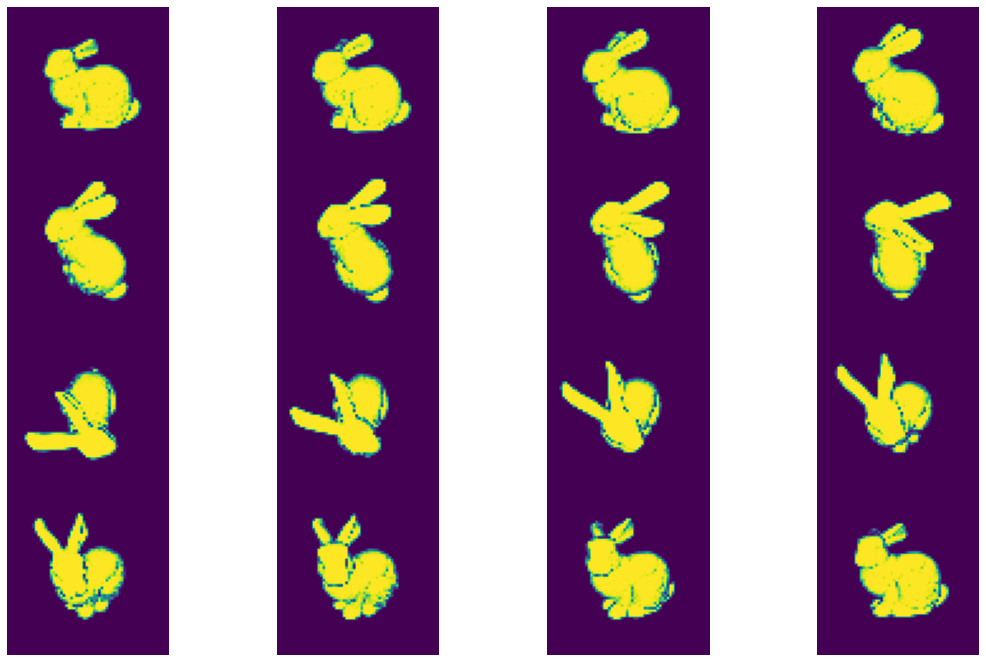

In [5]:
sigma = 1e-4
raster_settings_soft = RasterizationSettings(
    image_size=64, 
    blur_radius=np.log(1. / 1e-4 - 1.)*sigma, 
    faces_per_pixel=50, 
)

# Differentiable soft renderer using per vertex RGB colors for texture
renderer_silhouette = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=camera, 
        raster_settings=raster_settings_soft
    ),
    shader=SoftPhongShader(device=device, 
        cameras=camera,
        lights=lights)
)

# Render silhouette images.  The 3rd channel of the rendering output is 
# the alpha/silhouette channel
silhouette_images = renderer_silhouette(bunnies, cameras=cameras, lights=lights)
target_silhouette = [silhouette_images[i, ..., 0] for i in range(num_views)]

# Visualize silhouette images
image_grid(silhouette_images.cpu().numpy(), rows=4, cols=4, rgb=False)
plt.show()

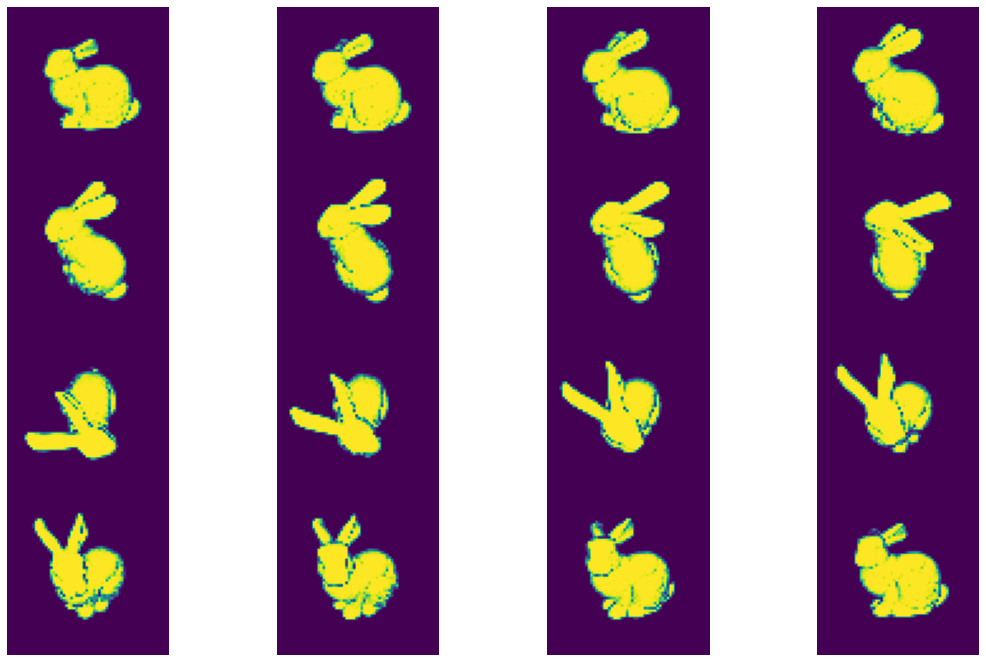

In [6]:
target_silhouette = [silhouette_images[i, ..., 3] for i in range(num_views)]

# Visualize silhouette images
image_grid(silhouette_images.cpu().numpy(), rows=4, cols=4, rgb=False)
plt.show()

In [7]:
n = 16
kernel = 11
cube = Cube(n, kernel=kernel, sigma=5, clip_value=0.1).to(device)

# self.gaussian(p.data.grad)

# clip_value = 0.1
# for p in cube.params.values():
#     #print(p)
#     p.register_hook(lambda grad: print(grad.shape) or torch.clamp(grad, -clip_value, clip_value))
#cube.export(f'./data/cube_mesh{n}.obj')

0.1


In [10]:
optimizer = torch.optim.SGD(cube.parameters(), lr=1., momentum=0.)
#optimizer = torch.optim.Adam(cube.parameters(), lr=0.001)
optimizer, cube

(SGD (
 Parameter Group 0
     dampening: 0
     lr: 1.0
     momentum: 0.0
     nesterov: False
     weight_decay: 0
 ),
 Cube(
   (params): ParameterDict(
       (back): Parameter containing: [torch.cuda.FloatTensor of size 1x3x16x16 (GPU 0)]
       (down): Parameter containing: [torch.cuda.FloatTensor of size 1x3x16x16 (GPU 0)]
       (front): Parameter containing: [torch.cuda.FloatTensor of size 1x3x16x16 (GPU 0)]
       (left): Parameter containing: [torch.cuda.FloatTensor of size 1x3x16x16 (GPU 0)]
       (right): Parameter containing: [torch.cuda.FloatTensor of size 1x3x16x16 (GPU 0)]
       (top): Parameter containing: [torch.cuda.FloatTensor of size 1x3x16x16 (GPU 0)]
   )
   (gaussian): DiscreteGaussian(
     (seq): Sequential(
       (0): ReflectionPad2d((5, 5, 5, 5))
       (1): Conv2d(3, 3, kernel_size=(11, 11), stride=(1, 1), groups=3, bias=False)
     )
   )
   (laplacian): DiscreteLaplacian(
     (seq): Sequential(
       (conv): Conv2d(3, 3, kernel_size=(3, 3), stride=

In [11]:
Niter = 10000
num_views_per_iteration = 2

loop = tqdm(range(Niter))

laplace_weight =  0.01

for i in loop:
    stop = False
#    with torch.autograd.detect_anomaly():
    optimizer.zero_grad()

    # Deform the mesh
    #new_src_mesh = src_mesh.offset_verts(torch.sigmoid(deform_verts))
    new_src_mesh, laplace_loss = cube.forward()
    #laplacian_smoothing = mesh_laplacian_smoothing(new_src_mesh, method="uniform")
    sum_loss = torch.tensor(0.0, device=device) #+ laplace_loss * laplace_weight
    #print(laplace_loss.item(), laplacian_smoothing.item())
#     sum_loss += mesh_edge_loss(new_src_mesh) * 1.0
#     sum_loss += mesh_normal_consistency(new_src_mesh) * 0.01
#     sum_loss += mesh_laplacian_smoothing(new_src_mesh, method="uniform") * 1.0
    
    # Compute the average silhouette loss over two random views, as the average 
    # squared L2 distance between the predicted silhouette and the target 
    # silhouette from our dataset
    for j in np.random.permutation(num_views).tolist()[:num_views_per_iteration]:
        images_predicted = renderer_silhouette(new_src_mesh, cameras=target_cameras[j], lights=lights)
        predicted_silhouette = images_predicted[..., 0]
        loss_silhouette = ((predicted_silhouette - target_silhouette[j]) ** 2).mean()
        if not torch.isnan(loss_silhouette):            
            sum_loss += loss_silhouette / num_views_per_iteration            
        else:
            print('singularity', i)
            #for p in cube.params.values():
            #    torch.nan_to_num_(p.data)
            #stop = True
    
    if stop:
        print(i)
        cube.export(f'./data/cube_mesh_{n}_{i}.obj')
#         pytorch3d.io.save_ply(f'./data/deformed{i}.ply', 
#             new_src_mesh.verts_packed(),
#             faces=new_src_mesh.faces_packed())
        break
        
    loop.set_description("total_loss = %.6f" % sum_loss)
    if sum_loss > 0:
        sum_loss.backward()
        #break
        optimizer.step()
    
    if i % 500 == 0:
        f = f'./data/cube_mesh_{n}_{i}.obj'
        cube.export(f)
        print(f)
#kernel = 0
f = f'./data/cube_mesh_{n}_{kernel}.obj'
cube.export(f)
f

./data/cube_mesh_16_0.obj
./data/cube_mesh_16_500.obj
./data/cube_mesh_16_1000.obj
./data/cube_mesh_16_1500.obj
./data/cube_mesh_16_2000.obj
singularity 2255
./data/cube_mesh_16_2500.obj
./data/cube_mesh_16_3000.obj
./data/cube_mesh_16_3500.obj
./data/cube_mesh_16_4000.obj
./data/cube_mesh_16_4500.obj
./data/cube_mesh_16_5000.obj
./data/cube_mesh_16_5500.obj
./data/cube_mesh_16_6000.obj
./data/cube_mesh_16_6500.obj
./data/cube_mesh_16_7000.obj
./data/cube_mesh_16_7500.obj
./data/cube_mesh_16_8000.obj
./data/cube_mesh_16_8500.obj



KeyboardInterrupt: 

In [15]:
cube.params['back'].grad.max()

tensor(5957.9546, device='cuda:0')

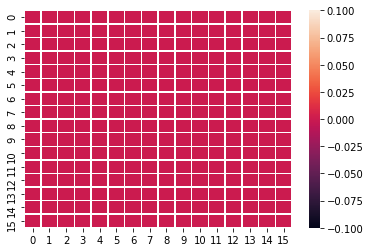

In [10]:
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt

k = cube.params['front'].grad.cpu()[0].permute(1, 2, 0).sum(dim=-1)
ax = sns.heatmap(k, linewidth=0.5)
plt.show()

In [20]:
k.shape, k[0].permute(1, 2, 0).mean(dim=-1).shape

(torch.Size([1, 3, 8, 8]), torch.Size([8, 8]))

In [11]:
torch.set_printoptions(precision=4,    sci_mode=False)
cube.params[0]['back']

KeyError: 0

In [9]:
from pytorch3d.io import save_obj

mesh, _ = cube.forward()
mesh = mesh.detach()
f = f'./data/cube_mesh_{n}.obj'
save_obj(f, mesh.verts_packed(), mesh.faces_packed())   

In [11]:
for p in cube.params.values():
    print(p.abs().max())

tensor(0.0631, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.1045, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.0825, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.1063, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.0400, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.0724, device='cuda:0', grad_fn=<MaxBackward1>)


In [ ]:
import torch.nn as nn

n = 8
params = nn.ParameterDict({
    'front': nn.Parameter(torch.zeros((1, 3, n, n))),
    'back' : nn.Parameter(torch.zeros((1, 3, n, n))),
    'left' : nn.Parameter(torch.zeros((1, 3, n, n))),
    'right': nn.Parameter(torch.zeros((1, 3, n, n))),
    'top'  : nn.Parameter(torch.zeros((1, 3, n, n))),
    'down' : nn.Parameter(torch.zeros((1, 3, n, n))),
})
params

In [ ]:
torch.cat([p[0].reshape(3, -1).t()
   for p in params.values()]).shape

In [ ]:
torch.cat([p for p in params.values()]).shape

In [ ]:
from src.discrete_laplacian import DiscreteLaplacian

laplacian = DiscreteLaplacian()
laplacian

In [ ]:
laplacian(torch.cat([p for p in params.values()]))

In [ ]:
ps = torch.cat([p for p in params.values()])
ps.shape

In [ ]:
ps.permute(0, 2, 3, 1).reshape(-1, 3).shape

In [ ]:
laplacian(ps)

In [ ]:
import torch.nn as nn

nn.Parameter()

In [ ]:
n = 2
params = nn.ParameterDict({
    'front': nn.Parameter(torch.zeros((1, 3, n, n))+0),
    'back' : nn.Parameter(torch.zeros((1, 3, n, n))+1),
    'left' : nn.Parameter(torch.zeros((1, 3, n, n))+2),
    'right': nn.Parameter(torch.zeros((1, 3, n, n))+3),
    'top'  : nn.Parameter(torch.zeros((1, 3, n, n))+4),
    'down' : nn.Parameter(torch.zeros((1, 3, n, n))+5),
})
params

In [ ]:
ps = torch.cat([p for p in params.values()])
deform_verts = ps.permute(0, 2, 3, 1).reshape(-1, 3)
ps

In [ ]:
ps.permute(0, 2, 3, 1)

In [ ]:
p1 = ps.permute(0, 2, 3, 1).reshape(-1, 3)
p2 = torch.cat([p[0].reshape(3, -1).t()
    for p in params.values()])  

In [ ]:
torch.equal(p1, p2)


In [ ]:
p1.contiguous()